# Show data about MEV relay bids
See .env.example to set the environment variables.

In [1]:
!pip install jupysql clickhouse_sqlalchemy matplotlib pandas python-dotenv > /dev/null 2>&1

In [2]:
import dotenv
import os

dotenv.load_dotenv()
network = os.getenv('NETWORK')
print(f"network: {network}")

network: mainnet


In [3]:
# Connect to ClickHouse
import os
from sqlalchemy import create_engine

username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')

print(f"username: {username}")
print(f"host: {host}")

db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"
engine = create_engine(db_url)
connection = engine.connect()

username: pandaops
host: clickhouse.xatu.ethpandaops.io


In [5]:
from sqlalchemy import text
import pandas as pd

# Define the filtering time range
start_date = '2024-11-01 00:00:00'
end_date = '2024-11-28 23:59:59'

print(f"Filtering results between {start_date} and {end_date} on {network}")

# Query for MEV bids per slot
query_bids_per_slot = text("""
SELECT
    slot,
    COUNT(*) AS num_bids
FROM
    mev_relay_bid_trace
WHERE
    slot_start_date_time >= :start_date
    AND slot_start_date_time < :end_date
    AND meta_network_name = :network
GROUP BY
    slot
ORDER BY
    slot
""")

# Execute the queries
bids_per_slot = pd.read_sql(query_bids_per_slot, connection, params={"start_date": start_date, "end_date": end_date, "network": network})

Filtering results between 2024-11-01 00:00:00 and 2024-11-28 23:59:59 on mainnet


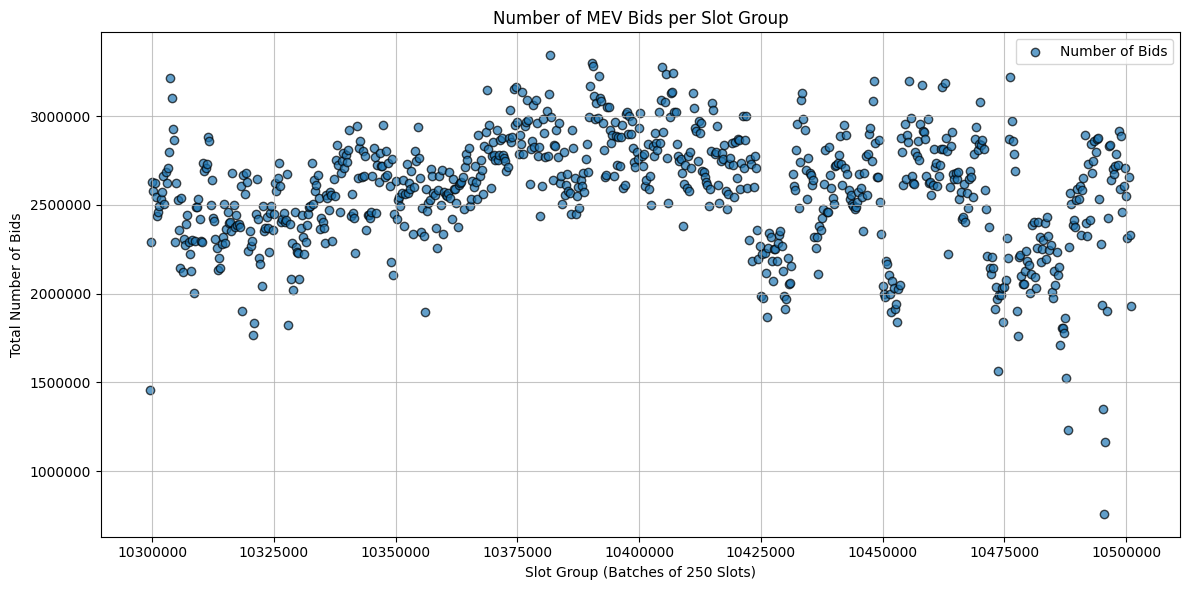

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Group slots into batches of 250
bids_per_slot["slot_group"] = (bids_per_slot["slot"] // 250) * 250

# Aggregate by slot group
binned_data = bids_per_slot.groupby("slot_group")["num_bids"].sum().reset_index()

# Plot binned data as a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(binned_data["slot_group"], binned_data["num_bids"], alpha=0.7, edgecolor="black", label="Number of Bids")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x)}"))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x)}"))
plt.xlabel("Slot Group (Batches of 250 Slots)")
plt.ylabel("Total Number of Bids")
plt.title("Number of MEV Bids per Slot Group")
plt.grid(True, alpha=0.75)
plt.tight_layout()
plt.legend()
plt.show()

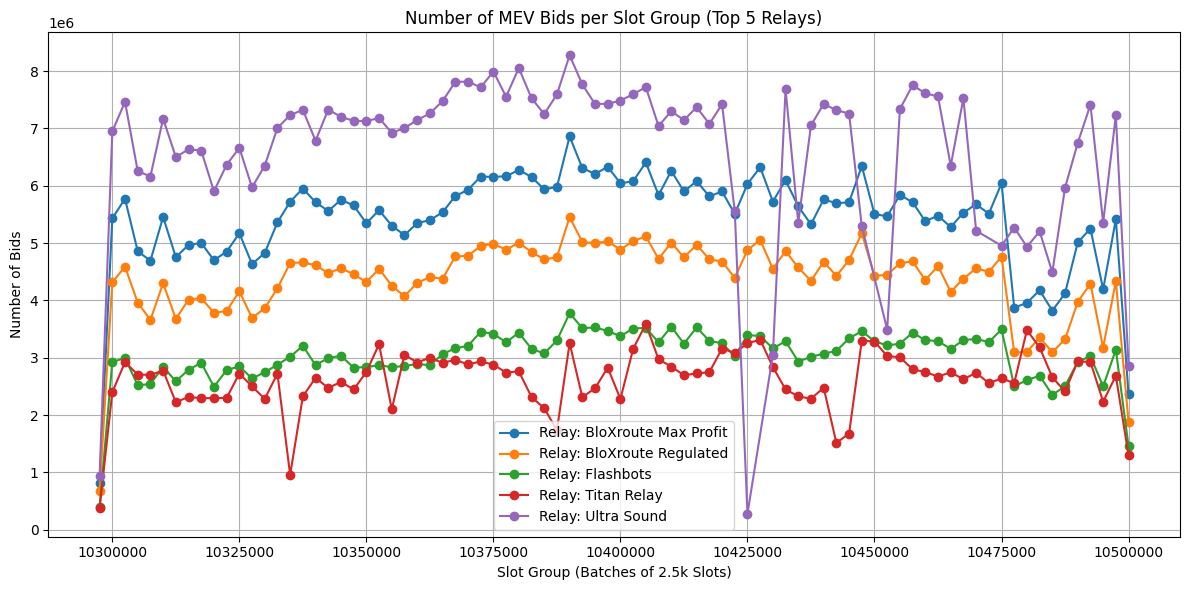

In [7]:
from sqlalchemy import text
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Query for MEV bids per slot per relay
query_bids_per_slot_per_relay = text("""
SELECT
    slot,
    relay_name,
    COUNT(*) AS num_bids
FROM
    mev_relay_bid_trace
WHERE
    slot_start_date_time >= :start_date
    AND slot_start_date_time < :end_date
    AND meta_network_name = 'mainnet'
GROUP BY
    slot, relay_name
ORDER BY
    slot, relay_name
""")

# Execute the queries
bids_per_slot_per_relay = pd.read_sql(query_bids_per_slot_per_relay, connection, params={"start_date": start_date, "end_date": end_date, "network": network})

# Group slots into batches of 2.5k
bids_per_slot_per_relay["slot_group"] = (bids_per_slot_per_relay["slot"] // 2500) * 2500

# Aggregate data by slot group and relay name
grouped_data = bids_per_slot_per_relay.groupby(["slot_group", "relay_name"])["num_bids"].sum().reset_index()

# Calculate total bids per relay and get top 5 relays
top_relays = grouped_data.groupby("relay_name")["num_bids"].sum().nlargest(5).index

# Filter data for top relays
top_relay_data = grouped_data[grouped_data["relay_name"].isin(top_relays)]

# Plot top relays only
plt.figure(figsize=(12, 6))
for relay_name, group in top_relay_data.groupby("relay_name"):
    plt.plot(group["slot_group"], group["num_bids"], marker='o', label=f"Relay: {relay_name}")

# Customize the x-axis to show actual slot ranges
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x)}"))
plt.xlabel("Slot Group (Batches of 2.5k Slots)")
plt.ylabel("Number of Bids")
plt.title(f"Number of MEV Bids per Slot Group (Top 5 Relays)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


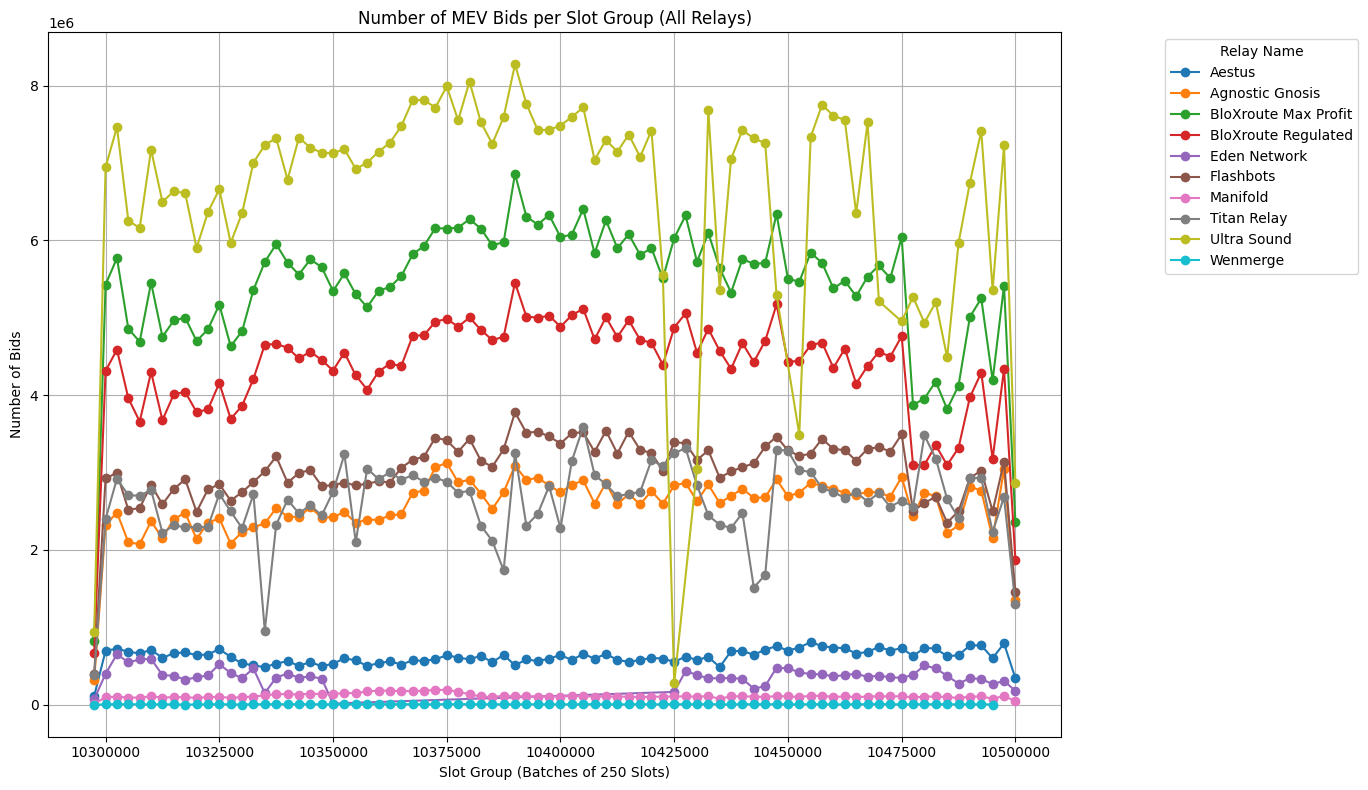

In [8]:
from sqlalchemy import text
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plot all relays
plt.figure(figsize=(14, 8))
for relay_name, group in grouped_data.groupby("relay_name"):
    plt.plot(group["slot_group"], group["num_bids"], marker='o', label=f"{relay_name}")

# Customize the x-axis to show actual slot ranges
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x)}"))
plt.xlabel("Slot Group (Batches of 250 Slots)")
plt.ylabel("Number of Bids")
plt.title(f"Number of MEV Bids per Slot Group (All Relays)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), title="Relay Name")  # Adjust legend position for readability
plt.grid(True)
plt.tight_layout()
plt.show()

